<a href="https://colab.research.google.com/github/moch1996/Vaycold/blob/main/Python_DataAnalysis/%EC%BD%94%EB%A1%9C%EB%82%98_%EB%B0%94%EC%9D%B4%EB%9F%AC%EC%8A%A4%EC%97%90_%EC%9D%98%ED%95%9C_%ED%99%95%EC%A7%84%EC%9E%90_%EC%88%98_%EB%B0%8F_%EC%82%AC%EB%A7%9D%EC%9E%90_%EC%88%98_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 데이터는 참고로 약 20년 1월 22일부터 21년 1월 22일까지의 데이터이며 누적확진자, 사망자 수이다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from math import sqrt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

In [2]:
df_case = pd.read_csv('RAW_global_confirmed_cases.csv')
df_death = pd.read_csv('RAW_global_deaths.csv')

In [3]:
df_case.head()

,Country/Region,Province/State,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20,12/19/20,12/20/20,12/21/20,12/22/20,12/23/20,12/24/20,12/25/20,12/26/20,12/27/20,12/28/20,12/29/20,12/30/20,12/31/20,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21,1/8/21,1/9/21,1/10/21,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21,1/21/21,1/22/21
0,Afghanistan,NaN,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,48718,48952,49161,49378,49621,49681,49817,50013,50190,50433,50655,50810,50886,51039,51280,51350,51405,51526,51526,51526,51526,53011,53105,53105,53207,53332,53400,53489,53538,53584,53584,53775,53831,53938,53984,54062,54141,54278,54403,54483
1,Albania,NaN,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,49191,50000,50637,51424,52004,52542,53003,53425,53814,54317,54827,55380,55755,56254,56572,57146,57727,58316,58316,58991,59438,59623,60283,61008,61705,62378,63033,63595,63971,64627,65334,65994,66635,67216,67690,67982,68568,69238,69916,70655
2,Algeria,NaN,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,92597,93065,93507,93933,94371,94781,95203,95659,96069,96549,97007,97441,97857,98249,98631,98988,99311,99610,99897,100159,100408,100645,100873,101120,101382,101657,101913,102144,102369,102641,102860,103127,103381,103611,103833,104092,104341,104606,104852,105124
3,Andorra,NaN,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,7382,7382,7446,7466,7519,7560,7577,7602,7633,7669,7699,7756,7806,7821,7875,7919,7983,8049,8117,8166,8192,8249,8308,8348,8348,8489,8586,8586,8586,8682,8818,8868,8946,9038,9083,9083,9194,9308,9379,9416
4,Angola,NaN,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,16277,16362,16407,16484,16562,16626,16644,16686,16802,16931,17029,17099,17149,17240,17296,17371,17433,17553,17568,17608,17642,17684,17756,17864,17974,18066,18156,18193,18254,18343,18425,18613,18679,18765,18875,18926,19011,19093,19177,19269


In [4]:
df_death.head()

,Country/Region,Province/State,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20,12/19/20,12/20/20,12/21/20,12/22/20,12/23/20,12/24/20,12/25/20,12/26/20,12/27/20,12/28/20,12/29/20,12/30/20,12/31/20,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21,1/8/21,1/9/21,1/10/21,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21,1/21/21,1/22/21
0,Afghanistan,NaN,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1969,1995,2011,2025,2030,2047,2067,2082,2096,2117,2126,2139,2149,2160,2174,2179,2181,2191,2191,2191,2191,2237,2244,2244,2253,2257,2264,2277,2288,2301,2301,2314,2324,2336,2339,2343,2346,2354,2363,2370
1,Albania,NaN,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1016,1028,1040,1055,1066,1074,1088,1098,1111,1117,1125,1134,1143,1153,1164,1170,1174,1181,1181,1190,1193,1199,1210,1217,1223,1230,1233,1241,1247,1252,1256,1261,1265,1270,1277,1281,1287,1291,1296,1303
2,Algeria,NaN,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2609,2623,2631,2640,2647,2659,2666,2675,2687,2696,2705,2716,2722,2728,2737,2745,2751,2756,2762,2769,2772,2777,2782,2786,2792,2798,2803,2807,2812,2816,2819,2822,2827,2831,2836,2840,2843,2849,2853,2856
3,Andorra,NaN,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,79,79,79,79,80,80,81,81,82,82,83,83,83,83,83,84,84,84,84,84,84,84,84,84,84,84,85,85,85,86,87,88,88,91,91,91,92,92,93,93
4,Angola,NaN,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,372,372,379,382,384,386,387,390,393,393,393,396,399,399,403,403,405,405,405,407,408,408,410,413,413,415,416,416,420,422,424,425,428,431,436,439,442,444,448,452


# 데이터 구조 변화 및 시각화

In [5]:
df_case['Country/Region'].value_counts()

China             33
Canada            16
France            12
United Kingdom    11
Australia          8
                  ..
India              1
Guinea-Bissau      1
Singapore          1
Eritrea            1
Micronesia         1
Name: Country/Region, Length: 192, dtype: int64

In [6]:
# 데이터프레임 구조를 date를 인덱스로, 지역을 컬럼으로 변경

In [7]:
df = df_case.drop(['Lat', 'Long'], axis=1).groupby('Country/Region').sum()
df = df.transpose()
df.index.name = 'Date' #인덱스 이름을 date로 바꾼 후
df.reset_index(inplace = True) #인덱스 값을 바꿀거임 우선 초기화 후
df['Date'] = df['Date'].apply(lambda s : pd.to_datetime(str(s)))
df.set_index('Date', inplace=True)
df

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei,Bulgaria,Burkina Faso,Burma,Burundi,Cabo Verde,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,Colombia,Comoros,Congo (Brazzaville),...,Serbia,Seychelles,Sierra Leone,Singapore,Slovakia,Slovenia,Solomon Islands,Somalia,South Africa,South Sudan,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Taiwan*,Tajikistan,Tanzania,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,548,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,643,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,920,0,0,0,...,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,5,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1406,0,0,0,...,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,6,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2075,0,0,0,...,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,8,0,0,0,0,0,5,0,0,0,0,0,0,0,0,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-18,54062,67982,104092,9083,18926,189,1807428,164676,28731,394939,227391,8067,97940,528329,1095,227360,679771,11592,3413,843,188733,118083,18630,8511770,174,212383,9352,134795,1245,13046,441,28010,719601,4973,2919,673750,98164,1923132,1769,7709,...,374111,746,3014,59127,224385,149424,17,4744,1346936,3703,2336451,53750,26279,7624,523486,499931,13132,862,13308,509,12594,52,4324,7399,181885,2392963,24078772,38085,1201894,256732,3443350,32863,78036,1,120444,1539,152555,2113,38207,27892
2021-01-19,54141,68568,104341,9194,19011,190,1819569,164912,28740,396425,227696,8068,98260,529031,1095,228716,681250,11615,3413,848,191090,118383,18630,8573864,174,212927,9352,135243,1253,13139,448,28010,724629,4973,2977,677151,98323,1939071,1864,7709,...,375799,746,3030,59157,226294,151137,17,4744,1356716,3762,2370742,54419,26279,7709,533265,502191,13224,868,13308,509,12653,52,4383,7415,184483,2399781,24256028,38534,1206125,260223,3476804,33446,78091,1,121117,1540,153093,2115,39515,28675
2021-01-20,54278,69238,104606,9308,19093,190,1831681,165221,28749,398096,228028,8075,98573,529687,1156,230494,684256,11642,3557,850,193745,118717,18630,8638249,174,213409,9553,135721,1322,13224,453,28010,730330,4974,3012,680740,98544,1956979,1933,7709,...,377445,762,3030,59197,228778,152851,17,4744,1369426,3773,2412318,55189,26279,7783,537967,504918,13313,870,13308,509,12795,53,4459,7430,188373,2406216,24438723,38628,1210854,263729,3515796,34294,78163,1,121691,1544,153590,2115,40949,29408


In [8]:
def fix_dataframe(df) :
  # 불필요한 데이터프레임제거, date를 datatime객체로 변환, date를 인덱스로 변환
  df = df.drop(['Lat', 'Long'], axis=1).groupby('Country/Region').sum()
  df = df.transpose()
  df.index.name = 'Date' #인덱스 이름을 date로 바꾼 후
  df.reset_index(inplace = True) #인덱스 값을 바꿀거임 우선 초기화 후
  df['Date'] = df['Date'].apply(lambda s : pd.to_datetime(str(s)))
  df.set_index('Date', inplace=True)
  return df

In [9]:
fix_dataframe(df_death)

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei,Bulgaria,Burkina Faso,Burma,Burundi,Cabo Verde,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,Colombia,Comoros,Congo (Brazzaville),...,Serbia,Seychelles,Sierra Leone,Singapore,Slovakia,Slovenia,Solomon Islands,Somalia,South Africa,South Sudan,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Taiwan*,Tajikistan,Tanzania,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,56,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-18,2343,1281,2840,91,439,6,45832,2998,909,7122,3022,175,360,7922,7,1591,20472,282,46,1,9680,4486,88,210299,3,8565,105,2973,2,120,0,455,18130,63,113,17547,4798,49004,49,114,...,3771,2,77,29,3526,3206,0,130,37449,63,53769,270,1603,145,10323,8792,841,7,90,21,70,0,74,132,5750,24161,399003,304,21847,751,90031,319,619,0,1112,35,1726,612,559,773
2021-01-19,2346,1287,2843,92,442,6,46066,3007,909,7199,3032,175,362,7942,7,1601,20554,283,46,1,9722,4509,88,211491,3,8614,105,2986,2,120,0,455,18289,63,114,17573,4800,49402,51,114,...,3791,2,77,29,3637,3231,0,130,38288,64,54173,273,1603,146,10323,8859,850,7,90,21,71,0,74,132,5844,24328,401772,305,22037,756,91643,330,620,0,1116,35,1741,612,578,825
2021-01-20,2354,1291,2849,92,444,6,46216,3016,909,7237,3044,175,366,7950,9,1610,20572,286,46,1,9764,4521,88,212831,3,8651,106,2997,2,121,0,455,18416,63,114,17594,4801,49792,54,114,...,3810,2,77,29,3737,3257,0,130,38854,64,54637,274,1603,146,10797,8924,858,7,90,21,71,0,74,133,5921,24487,406147,305,22264,762,93469,336,620,0,1122,35,1751,612,585,879


In [10]:
df_case = fix_dataframe(df_case)
df_death = fix_dataframe(df_death)

In [11]:
df_death.head()

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei,Bulgaria,Burkina Faso,Burma,Burundi,Cabo Verde,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,Colombia,Comoros,Congo (Brazzaville),...,Serbia,Seychelles,Sierra Leone,Singapore,Slovakia,Slovenia,Solomon Islands,Somalia,South Africa,South Sudan,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Taiwan*,Tajikistan,Tanzania,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,56,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
# 나라별 확진자 수 및 사망자 수 시각화하기
# 최신일자, 가장 많이 확진된 10국가

In [13]:
# 마지막 날짜의 누적확진자 수를 볼까??
top_ten_cases = df_case.loc[df_case.index[-1]].sort_values(ascending=False)[:10]
top_ten_cases

Country/Region
US                24818779
India             10639684
Brazil             8753920
Russia             3637862
United Kingdom     3594094
France             3069695
Spain              2499560
Italy              2441854
Turkey             2418472
Germany            2125261
Name: 2021-01-22 00:00:00, dtype: int64

In [14]:
# 마지막 날짜의 누적사망자 수를 볼까용
top_ten_deaths = df_death.loc[df_death.index[-1]][top_ten_cases.index] #top_ten_cases.index가 포인트
top_ten_deaths

# 한 그래프 내에 표시해야 되기 때문에 소팅할 때 주의가 필요함.
# 다른 데이터프레임에서 가져온 거기 때문에 소팅했을 때 순서가 다를 수 있음. 
# 그러므로 탑텐 케이스에서 소팅한 값기준으로 데스값을 소팅해야댐

Country/Region
US                414004
India             153184
Brazil            215243
Russia             67376
United Kingdom     96166
France             72788
Spain              55441
Italy              84674
Turkey             24789
Germany            51713
Name: 2021-01-22 00:00:00, dtype: int64

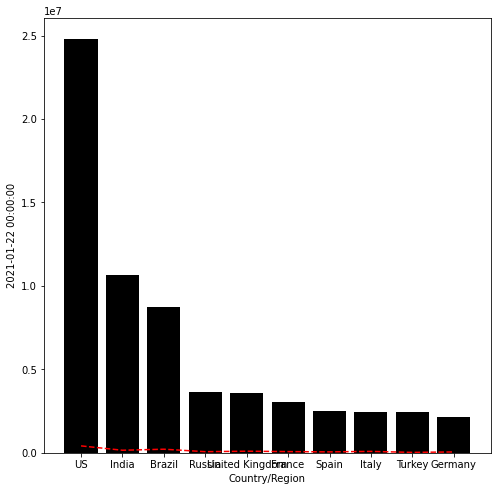

In [15]:
plt.figure(figsize=(8,8))
sns.barplot(x =top_ten_cases.index, y=top_ten_cases, color='black')
plt.plot(top_ten_deaths.index, top_ten_deaths, 'r--')
plt.show()
#뭐여 빨간선이 바닥에 기고있넹??   스케일링을 다르게 해줘야 됨
# 어떻게 하냐면 twinx를 사용해야됨


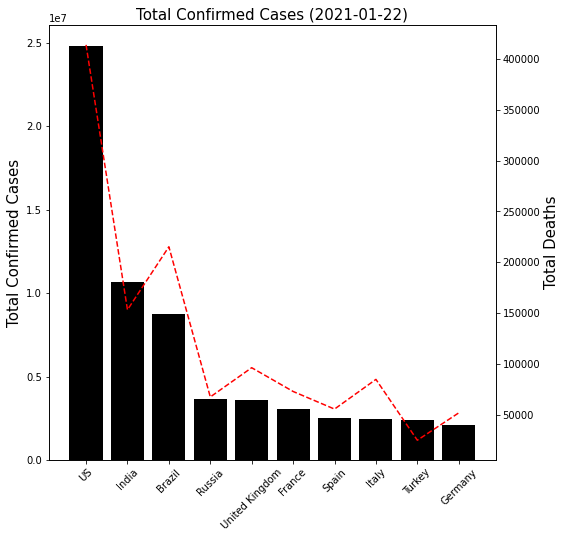

In [16]:
plt.figure(figsize=(8,8))
sns.barplot(x =top_ten_cases.index, y=top_ten_cases, color='black')
plt.xticks(rotation=45, size=10)
plt.ylabel('Total Confirmed Cases', size=15)
plt.xlabel('', size=15)
plt.title('Total Confirmed Cases (%s)' % top_ten_cases.name.strftime('%Y-%m-%d'), size=15)


ax = plt.gca()
ax2 = ax.twinx() #동일한 x를 공유하면서 서로 다른 y를 가지는 것임
ax2.plot(top_ten_deaths.index, top_ten_deaths, 'r--')
ax2.set_ylabel('Total Deaths', size=15)
plt.show()



In [17]:
# 나라별 시간에 따른 확진자 수 및 사망자 수 시각화하기

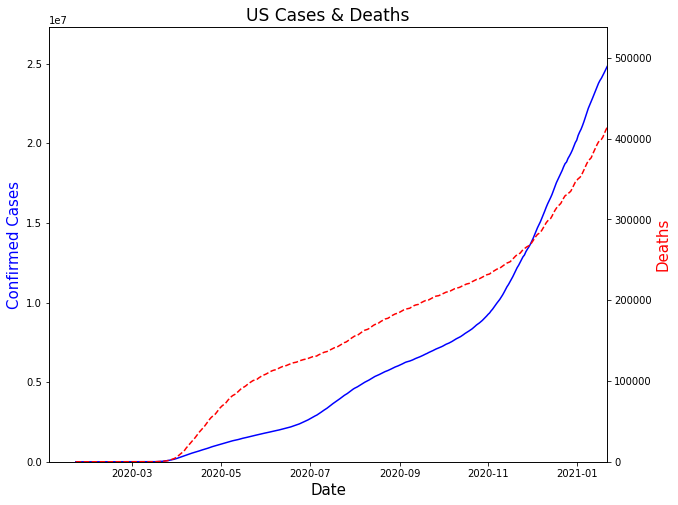

In [18]:
country = 'US'
plt.figure(figsize=(10,8))
plt.plot(df_case.US.index,df_case.US,'b-')
plt.ylabel('Confirmed Cases', color='blue',size=15)
plt.title(country +' Cases & Deaths',size=17)
plt.xlim(right = df_case.index[-1])
plt.ylim(0, df_case[country].max()*1.1)
plt.xlabel('Date',size=15)

ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(df_death.index,df_death[country], 'r--')
ax2.set_ylabel('Deaths', color='red', size=15)
ax2.set_ylim(0, df_death[country].max()*1.3)
plt.show()


In [19]:
df_case.columns

Index(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria',
       ...
       'United Kingdom', 'Uruguay', 'Uzbekistan', 'Vanuatu', 'Venezuela',
       'Vietnam', 'West Bank and Gaza', 'Yemen', 'Zambia', 'Zimbabwe'],
      dtype='object', name='Country/Region', length=192)

In [20]:
def plot_case_with_death(country) :
      
    plt.figure(figsize=(10,8))
    plt.plot(df_case.index,df_case[country],'b-')
    plt.ylabel('Confirmed Cases', color='blue',size=15)
    plt.title(country +' Cases & Deaths',size=17)
    plt.xlim(right = df_case.index[-1])
    plt.ylim(0, df_case[country].max()*1.1)
    plt.xlabel('Date',size=15)

    ax = plt.gca()
    ax2 = ax.twinx()
    ax2.plot(df_death.index,df_death[country], 'r--')
    ax2.set_ylabel('Deaths', color='red', size=15)
    ax2.set_ylim(0, df_death[country].max()*1.3)
    plt.show()

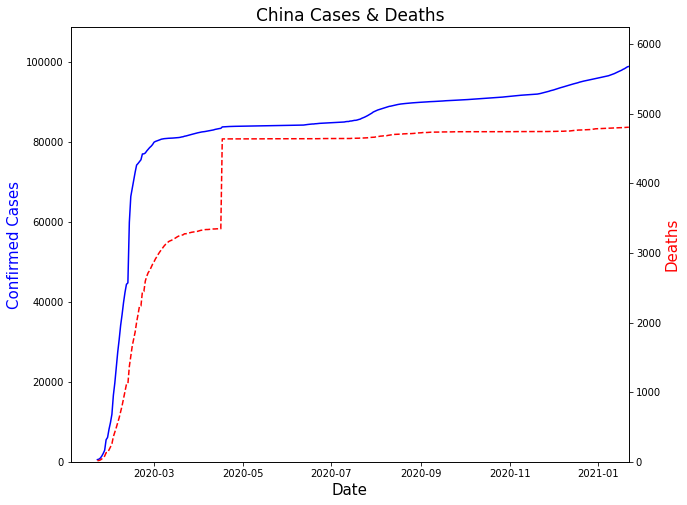

In [21]:
plot_case_with_death('China')

In [22]:
# 한국의 확진자 수 및 사망자 수 변화 시각화 분석

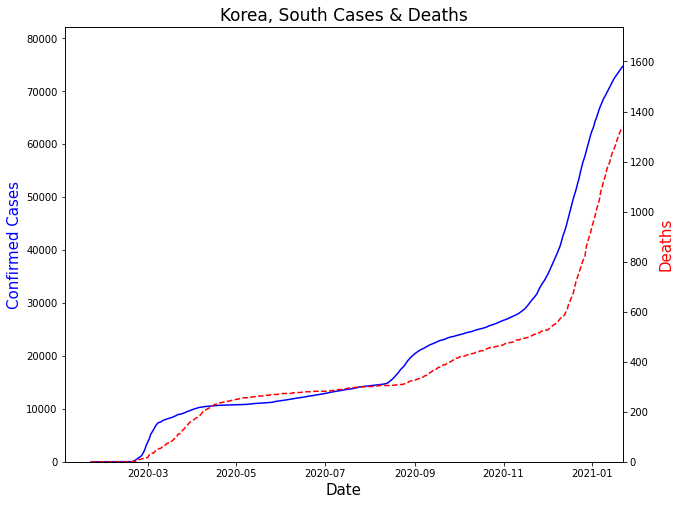

In [23]:
plot_case_with_death('Korea, South')

In [24]:
# 한국의 일일확진자 수 / 사망자 수 시각화 및 분석
# 누적된 데이터에서 diff() 를 추가해주면 간단히 됨

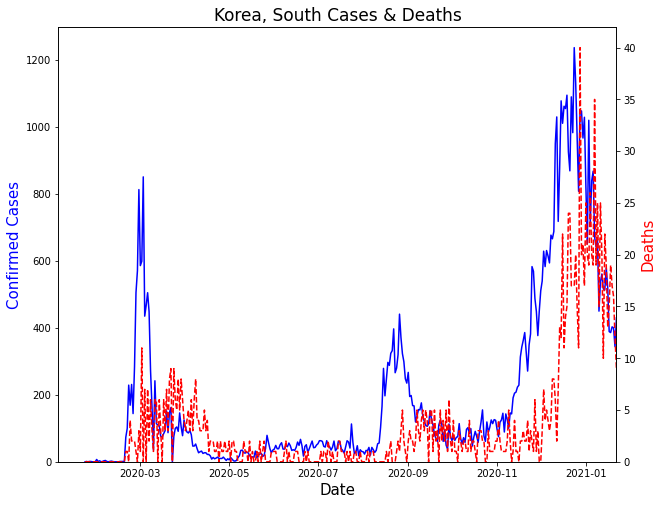

In [25]:
country = 'Korea, South'
plt.figure(figsize=(10,8))
plt.plot(df_case.index,df_case[country].diff(),'b-')
plt.ylabel('Confirmed Cases', color='blue',size=15)
plt.title(country +' Cases & Deaths',size=17)
plt.xlim(right = df_case.index[-1])
plt.ylim(bottom = 0)
plt.xlabel('Date',size=15)

ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(df_death.index,df_death[country].diff(), 'r--')
ax2.set_ylabel('Deaths', color='red', size=15)
ax2.set_ylim(bottom = 0)
plt.show()

In [26]:
# Plotly의 Choropleth 데이터 포맷사용

In [27]:
import plotly.graph_objects as go

In [28]:
df_code = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv')

In [29]:
df_code

# 이 데이터프레임을 이용하여 국가명을 국가코드로 변환할거임

,COUNTRY,GDP (BILLIONS),CODE
0,Afghanistan,21.71,AFG
1,Albania,13.40,ALB
2,Algeria,227.80,DZA
3,American Samoa,0.75,ASM
4,Andorra,4.80,AND
...,...,...,...
217,Virgin Islands,5.08,VGB
218,West Bank,6.64,WBG
219,Yemen,45.45,YEM
220,Zambia,25.61,ZMB


In [30]:
# 이름이 다르게 쓰인 국가의 이름을 먼저 변경한 후 코드 변경

country_renamer = {
    'Bahamas':'Bahamas, The',
    'Congo (Brazzaville)':'Congo, Republic of the',
    'Congo (Kinshasa)':'Congo, Democratic Republic of the',
    'Czechia':'Czech Republic',
    'Eswatini':'Swaziland',
    'Gambia':'Gambia, The',
    'North Macedonia':'Macedonia',
    'Taiwan*':'Taiwan',
    'US':'United States',
    'West Bank and Gaza':'West Bank'
}

In [31]:
# plotly 공식 레퍼런스 : https://plotly.com/python/choropleth-maps/#world-choropleth-map

In [33]:
def get_choropleth_data(date) :

  data=go.Choropleth(
      locations = df['CODE'],
      z = df['GDP (BILLIONS)'],
      text = df['COUNTRY'],
      colorscale = 'Blues',
      autocolorscale=False,
      reversescale=True,
      marker_line_color='darkgray',
      marker_line_width=0.5,
      colorbar_tickprefix = '',
      colorbar_title = 'Confirmed Cases',
  )

  return data

In [ ]:
# 위 함수에 location, z, text를 만들어서 넣어주면 될듯

In [34]:
df.columns

Index(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria',
       ...
       'United Kingdom', 'Uruguay', 'Uzbekistan', 'Vanuatu', 'Venezuela',
       'Vietnam', 'West Bank and Gaza', 'Yemen', 'Zambia', 'Zimbabwe'],
      dtype='object', name='Country/Region', length=192)

In [37]:
#df_case.columns.map(country_renamer) # 이렇게하면 counry renamer에 없는 값들이 전부 NaN이 됨
df_c= df_case.rename(country_renamer,axis=1).copy() # rename을 사용하면 컬럼에 매핑을 할 수 있음., 없는 것들은 유지, 있는 것들은 따라 바뀜

In [39]:
df_code.head()

,COUNTRY,GDP (BILLIONS),CODE
0,Afghanistan,21.71,AFG
1,Albania,13.40,ALB
2,Algeria,227.80,DZA
3,American Samoa,0.75,ASM
4,Andorra,4.80,AND


In [43]:
#df_code를 이용해서 country를 code로 바꿀 수 있는 레퍼런스를 만들자

In [46]:
df_code.set_index('COUNTRY') # COUNTRY를 기준으로 인덱싱한다
country_to_code = df_code.set_index('COUNTRY')['CODE']

In [47]:
for col in df_c.columns :
  if col not in country_to_code.index :
    df_c.drop(col, axis=1, inplace=True)

df_code = df_c.rename(country_to_code, axis=1)

In [48]:
df_code

Country/Region,AFG,ALB,DZA,AND,AGO,ATG,ARG,ARM,AUS,AUT,AZE,BHM,BHR,BGD,BRB,BLR,BEL,BLZ,BEN,BTN,BOL,BIH,BWA,BRA,BRN,BGR,BFA,MMR,BDI,CPV,KHM,CMR,CAN,CAF,TCD,CHL,CHN,COL,COM,COG,...,SRB,SYC,SLE,SGP,SVK,SVN,SLB,SOM,ZAF,SSD,ESP,LKA,SDN,SUR,SWE,CHE,SYR,TWN,TJK,TZA,THA,TLS,TGO,TTO,TUN,TUR,USA,UGA,UKR,ARE,GBR,URY,UZB,VUT,VEN,VNM,WBG,YEM,ZMB,ZWE
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,548,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,643,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,920,0,0,0,...,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,5,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1406,0,0,0,...,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,6,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2075,0,0,0,...,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,8,0,0,0,0,0,5,0,0,0,0,0,0,0,0,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-18,54062,67982,104092,9083,18926,189,1807428,164676,28731,394939,227391,8067,97940,528329,1095,227360,679771,11592,3413,843,188733,118083,18630,8511770,174,212383,9352,134795,1245,13046,441,28010,719601,4973,2919,673750,98164,1923132,1769,7709,...,374111,746,3014,59127,224385,149424,17,4744,1346936,3703,2336451,53750,26279,7624,523486,499931,13132,862,13308,509,12594,52,4324,7399,181885,2392963,24078772,38085,1201894,256732,3443350,32863,78036,1,120444,1539,152555,2113,38207,27892
2021-01-19,54141,68568,104341,9194,19011,190,1819569,164912,28740,396425,227696,8068,98260,529031,1095,228716,681250,11615,3413,848,191090,118383,18630,8573864,174,212927,9352,135243,1253,13139,448,28010,724629,4973,2977,677151,98323,1939071,1864,7709,...,375799,746,3030,59157,226294,151137,17,4744,1356716,3762,2370742,54419,26279,7709,533265,502191,13224,868,13308,509,12653,52,4383,7415,184483,2399781,24256028,38534,1206125,260223,3476804,33446,78091,1,121117,1540,153093,2115,39515,28675
2021-01-20,54278,69238,104606,9308,19093,190,1831681,165221,28749,398096,228028,8075,98573,529687,1156,230494,684256,11642,3557,850,193745,118717,18630,8638249,174,213409,9553,135721,1322,13224,453,28010,730330,4974,3012,680740,98544,1956979,1933,7709,...,377445,762,3030,59197,228778,152851,17,4744,1369426,3773,2412318,55189,26279,7783,537967,504918,13313,870,13308,509,12795,53,4459,7430,188373,2406216,24438723,38628,1210854,263729,3515796,34294,78163,1,121691,1544,153590,2115,40949,29408


In [51]:
def get_choropleth_data(date) :

  data=go.Choropleth(
      locations = df_code.columns,
      z = df_code.loc[date],
      text = df_c.columns,
      colorscale = 'Blues',
      autocolorscale=False,
      reversescale=True,
      marker_line_color='darkgray',
      marker_line_width=0.5,
      colorbar_tickprefix = '',
      colorbar_title = 'Confirmed Cases',
  )

  return data

In [53]:
# Choropleth 시각화
date = df_case.index[-1]
data = get_choropleth_data(date)
fig = go.Figure(data=data)
fig.update_layout(
    title_text='Confirmed Cases in ' + str(date),
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    )
    )

fig.show()

# 모델학습

In [61]:
# FBProphet 학습을 위한 데이터프레임 생성
# 한국의 확진자 수 데이터를 FBProphet에 학습하기 위한 데이터프레임 재구성

In [58]:
df_case.head(2)

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei,Bulgaria,Burkina Faso,Burma,Burundi,Cabo Verde,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,Colombia,Comoros,Congo (Brazzaville),...,Serbia,Seychelles,Sierra Leone,Singapore,Slovakia,Slovenia,Solomon Islands,Somalia,South Africa,South Sudan,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Taiwan*,Tajikistan,Tanzania,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,548,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,643,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0


In [59]:
df_case.reset_index().head(2)

Country/Region,Date,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei,Bulgaria,Burkina Faso,Burma,Burundi,Cabo Verde,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,Colombia,Comoros,...,Serbia,Seychelles,Sierra Leone,Singapore,Slovakia,Slovenia,Solomon Islands,Somalia,South Africa,South Sudan,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Taiwan*,Tajikistan,Tanzania,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
0,2020-01-22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,548,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2020-01-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,643,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0


In [62]:
df_case.reset_index().head(2)[['Date','Korea, South']]

Country/Region,Date,"Korea, South"
0,2020-01-22,1
1,2020-01-23,1


In [64]:
df = pd.DataFrame(df_case.reset_index()[['Date','Korea, South']].to_numpy(), columns=['ds','y'])
df

,ds,y
0,2020-01-22,1
1,2020-01-23,1
2,2020-01-24,2
3,2020-01-25,2
4,2020-01-26,3
...,...,...
362,2021-01-18,73115
363,2021-01-19,73518
364,2021-01-20,73918
365,2021-01-21,74262


In [65]:
# 비율에 따라 테스트/ 학습 데이터 프레임으로 나누어 반환
from math import floor

In [ ]:
def split_df(df, test_size) :
  div = floor(df.shape)

In [68]:
def train_test_split_df(df, test_size) :
  div = floor(df.shape[0]*(1-test_size))
  return df.loc[:div], df.loc[div:]

In [69]:
train_df, test_df = train_test_split_df(df,0.1)

NameError: ignored